In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
data = pd.read_csv('Online_retail.csv', encoding="ISO-8859-1")

In [ ]:
#convert InvoiceDate to date time format

#convert InvoiceDate to date time format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M', errors='coerce')

# Filter out rows with UnitPrice of 0
data = data[data['UnitPrice'] > 0]

# Flag returns by checking if InvoiceNo starts with 'C'
data['IsReturn'] = data['InvoiceNo'].astype(str).str.startswith('C')

# Calculate TotalSpending, where returns are subtracted from the total
data['TotalSpending'] = data.apply(
    lambda x: -x['Quantity'] * x['UnitPrice'] if x['IsReturn'] else x['Quantity'] * x['UnitPrice'], axis=1
)
#aggregate to get customer level data
customer_data = data.groupby('CustomerID').agg({
     'TotalSpending': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'mean'
}).rename(columns={'InvoiceNo': 'OrderFrequency', 'Quantity': 'AvgOrderSize'}).reset_index()

In [ ]:
#standardize feature
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalSpending', 'OrderFrequency', 'AvgOrderSize']])

In [ ]:
#apply kmeans
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

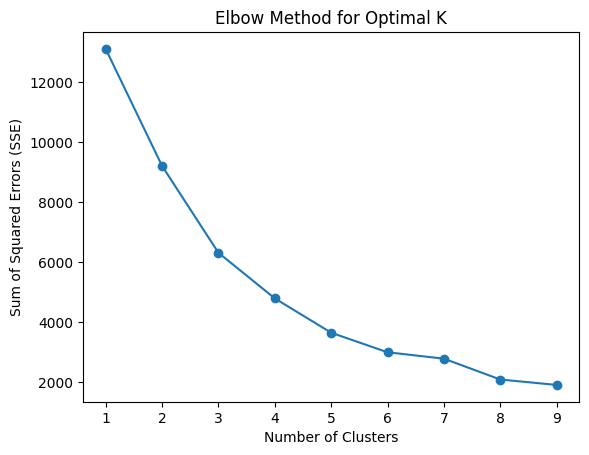

In [ ]:
# Plot the elbow curve
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

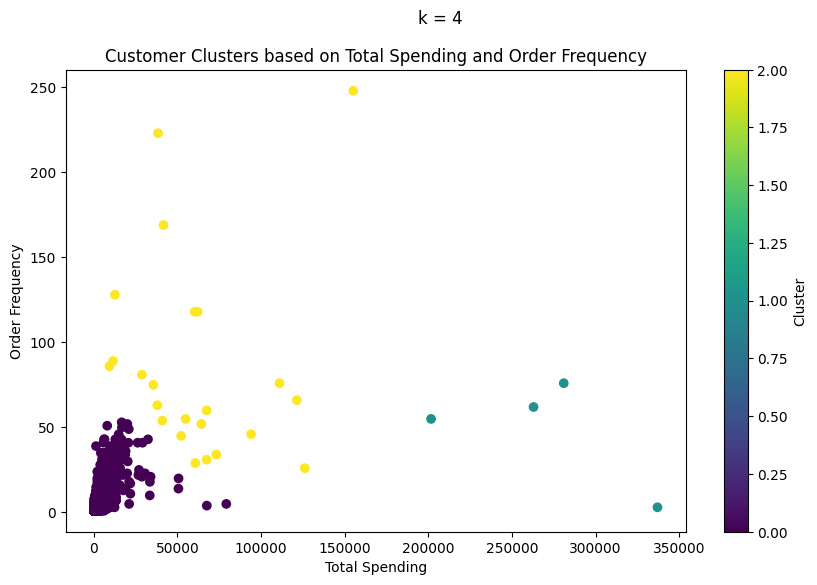

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'OrderFrequency': 'mean',
    'AvgOrderSize': 'mean'
})

x = customer_data['TotalSpending']
y = customer_data['OrderFrequency']
labels = customer_data['Cluster']

# Create a 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=labels, cmap='viridis', marker='o')
plt.xlabel('Total Spending')
plt.ylabel('Order Frequency')
plt.title('Customer Clusters based on Total Spending and Order Frequency')
plt.suptitle('k = 4')
# Add a color bar to indicate clusters
plt.colorbar(label='Cluster')

plt.show()

In [ ]:

# Calculate the frequency of items ordered
item_frequency = data.groupby(['Description', 'CustomerID'])['Quantity'].sum().reset_index()

# Merge item frequency with customer data to include clusters
merged_data = pd.merge(item_frequency, customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Now, aggregate the frequency of each item by cluster
item_cluster_frequency = merged_data.groupby(['Description', 'Cluster'])['Quantity'].sum().reset_index()

# Sort the items within each cluster by quantity in descending order
item_cluster_frequency = item_cluster_frequency.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])

# Display the result
print(item_cluster_frequency.head(20))

                             Description  Cluster  Quantity
7679   WORLD WAR 2 GLIDERS ASSTD DESIGNS        0     51864
406        ASSORTED COLOUR BIRD ORNAMENT        0     32108
3506             JUMBO BAG RED RETROSPOT        0     30136
4476           PACK OF 12 LONDON TISSUES        0     24345
7495  WHITE HANGING HEART T-LIGHT HOLDER        0     24241
4563     PACK OF 72 RETROSPOT CAKE CASES        0     23888
5305                  RABBIT NIGHT LIGHT        0     20108
4557  PACK OF 60 PINK PAISLEY CAKE CASES        0     20092
4108              MINI PAINT SET VINTAGE        0     19896
5207                      POPCORN HOLDER        0     18692
5357               RED  HARMONICA IN BOX        0     18457
7154     VICTORIAN GLASS HANGING T-LIGHT        0     17930
420            ASSORTED COLOURS SILK FAN        0     16812
213          60 TEATIME FAIRY CAKE CASES        0     14247
6621                SMALL POPCORN HOLDER        0     13767
4654      PAPER CHAIN KIT 50'S CHRISTMAS

In [ ]:
# Group the data by cluster
clusters = customer_data.groupby('Cluster')

# For each cluster, sample two examples and print them
for cluster_id, cluster_data in clusters:
    print(f"\nCluster {cluster_id} - Sample Customers:")
    # Sample a maximum of 2, or the entire cluster if it's smaller
    num_samples = min(len(cluster_data), 2)
    examples = cluster_data.sample(num_samples, random_state=42)
    print(examples[['CustomerID', 'TotalSpending', 'OrderFrequency', 'AvgOrderSize']])


Cluster 0 - Sample Customers:
      CustomerID  TotalSpending  OrderFrequency  AvgOrderSize
2583     15832.0         836.79               1      8.611111
319      12733.0         383.95               1      6.227273

Cluster 1 - Sample Customers:
      CustomerID  TotalSpending  OrderFrequency  AvgOrderSize
3031     16446.0      336942.10               3       0.50000
4231     18102.0      262876.11              62     148.08776

Cluster 2 - Sample Customers:
      CustomerID  TotalSpending  OrderFrequency  AvgOrderSize
2535     15769.0       60681.72              29    188.163265
1445     14298.0       52192.16              45     35.378659


Total Spending in Each Cluster:
Cluster
0    6859467.844
1    1082360.640
2    1426554.310
Name: TotalSpending, dtype: float64


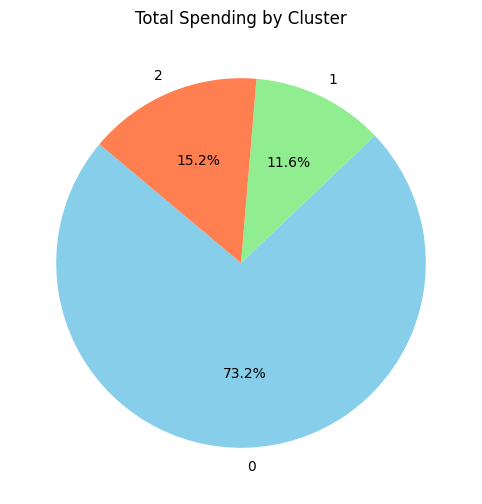

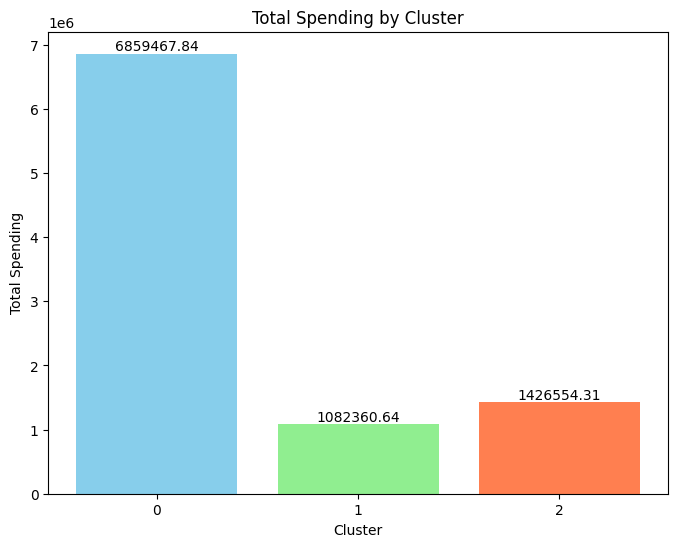

In [ ]:
#finding total spending in each cluster
# Calculate the total spending in each cluster
cluster_spending = customer_data.groupby('Cluster')['TotalSpending'].sum()

# Display the result
print("Total Spending in Each Cluster:")
print(cluster_spending)

# Plot a pie chart for the total spending in each cluster
plt.figure(figsize=(8, 6))
plt.pie(cluster_spending, labels=cluster_spending.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'coral', 'gold'])
plt.title('Total Spending by Cluster')
plt.show()



# Plot a bar chart for the total spending in each cluster
plt.figure(figsize=(8, 6))
bars = plt.bar(cluster_spending.index, cluster_spending.values, color=['skyblue', 'lightgreen', 'coral', 'gold'])

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')  # Format to 2 decimal places

plt.xlabel('Cluster')
plt.ylabel('Total Spending')
plt.title('Total Spending by Cluster')
plt.xticks(cluster_spending.index)  # Ensure clusters are labeled on x-axis
plt.show()